<a href="https://colab.research.google.com/github/Anonymous1846/ALL-Detection-Using-CNN/blob/master/ALL_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing All The Necessary Dependancies.**

In [22]:
'''
Importing all the necessary dependencies for the Binary Classification model !
In the end we have verified the keras installtion, by printing out the keras version.
keras/tensorflow - for developing and training the DL(CNN) model !
os,random - for selection of the images from the directory !
'''
from keras.layers import MaxPooling2D,Conv2D,Dropout,Dense,Flatten,BatchNormalization,MaxPool2D #layers
from keras.preprocessing.image import ImageDataGenerator #for augmentation
from tensorflow.keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint # for checkpoint calculation and callback
from keras.preprocessing import image
from keras.models import Sequential
import matplotlib.pyplot as plt # for plotting 
import tensorflow as tf
import numpy as np
import keras
import os 
from cv2 import imread # reading the image via  a path 
#causes an error if the keras installtion didn't went well !
print(keras.__version__)

2.4.3


# **Loading the Dataset(i.e Cancer cell images).**

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
'''
The Images required for the training, validation, and testing is found in the /Architecture Datasets directory !
Architecture Datasets 
|
|
|
 ---- Training(80 %)
      |
      |
      ----Normal 
      |
      ----Blasts
|
|
---- Validation (10 %)
      |
      |
      ----Normal 
      |
      ----Blasts
|
|
---- Testing (10 %)
      |
      |
      ----Normal 
      |
      ----Blasts

      The images/dataset is divided into 80% training, 10% testing and 10% validation
'''
training_data_path="/content/drive/MyDrive/Architecture Datasets/Training"
validation_data_path="/content/drive/MyDrive/Architecture Datasets/Validation"
print(f'The Training Images Path :{training_data_path}')
print(f'The Validation Images Path :{validation_data_path}')



The Training Images Path :/content/drive/MyDrive/Architecture Datasets/Training
The Validation Images Path :/content/drive/MyDrive/Architecture Datasets/Validation


# **Image Preprocessing**

In [24]:
'''
ALL-IDB1 and ALL IDB2 both contains roughly 334 images, but after spiltting of the images,
the size becomes significantly low, and this leads significant amount of overfitting.
So, inorder to solve the problem of overfitting, we have to apply data augmentation to 
increase the number of images, from the previous existing images !
'''
training_images_preprocessed=ImageDataGenerator(rescale=1./255,
                                                rotation_range=40,
                                                horizontal_flip=True,
                                                fill_mode='nearest')
validate_images_preprocessed=ImageDataGenerator(rescale=1./255,rotation_range=40)


# **Applying the Image Augmentation to Training and Validation Set !**

In [53]:
'''
The function augments the data, according to the processing mode.
The processing mode has defined earlier seperately for training and validation set !

params:training/validation directory and the processing mode(different for training and validation dataset)

return:augmented data 
'''
def apply_augmentation(data_directory,processing_mode,is_alexnet):
  data_gen=validate_images_preprocessed.flow_from_directory(
        data_directory,  # the directory as provided to the function as an arguement !
        target_size=(300, 300) if not is_alexnet else (227,227),  # 300x 300 pixels 
        batch_size=128,
        class_mode='binary')
  return data_gen

training_images_datagen=apply_augmentation(training_data_path,training_images_preprocessed,True)
valid_images_datagen=apply_augmentation(validation_data_path,validate_images_preprocessed,True)

print(training_images_datagen.class_indices) # class indices refer to the numerical equivalent whether they are cancerours or not !


Found 268 images belonging to 2 classes.
Found 33 images belonging to 2 classes.
{'Blasts': 0, 'Normal': 1}


#**Using the mean pixel we have calculated the number of features !**

In [46]:
sample_image0=imread('/content/drive/MyDrive/Architecture Datasets/Training/Blasts/Im031_1.jpg')
print("The diemensions of the cancer cell: {}".format(sample_image0.shape))
feature_matrix0 = np.zeros((sample_image0.shape[0], sample_image0.shape[1])) # for cancer cell

'''
The function will calculate the mean pixels values which are essential in understanding the number of possible 
values/ features in the image !

params: fetaure matrix and image

return: None
'''
def show_features(feature_matrix,img):
  for i in range(1,img.shape[0]):
    for j in range(1,img.shape[1]):
        feature_matrix[i][j] = ((int(img[i,j,0]) + int(img[i,j,1]) + int(img[i,j,2]))/3) # mean for three channels !

  features = np.reshape(feature_matrix, (img.shape[0]*img.shape[1])) 
  print("The mean pixels values for the cancer cells: {}".format(features.shape[0]))
show_features(feature_matrix0,sample_image0) # for cancer cell 


The diemensions of the cancer cell: (1368, 1712, 3)
The mean pixels values for the cancer cells: 2342016


# **Representation of Images.**

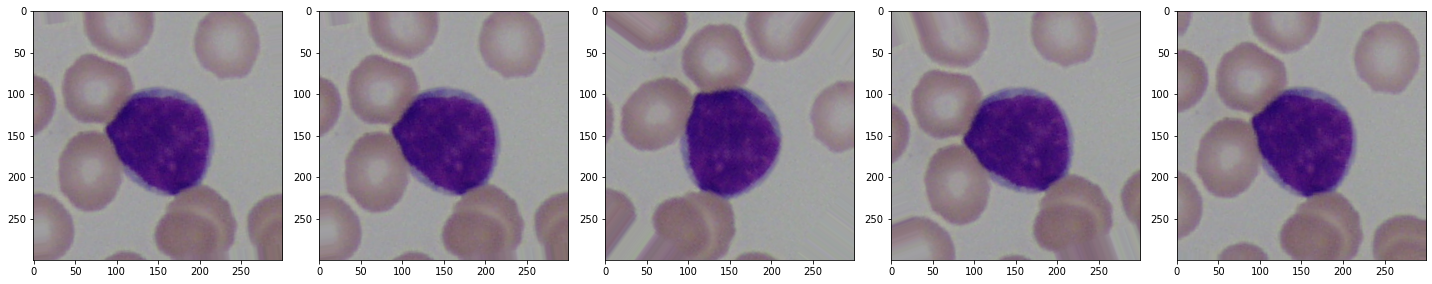

In [35]:
'''
The function is used to plot the augmented figures of the images, for visual demonstartion !

params:image object
return: 5 plotted images
'''
def plot(image):
  fig,axes=plt.subplots(1,5,figsize=(20,20))# 20 x 20 images 
  axes=axes.flatten()
  for imag,axis in zip(image,axes):
    #the zip function takes two params(iteratables and combines then to form a list of tuples !)
    axis.imshow(imag)
  plt.tight_layout()
  plt.show()

training_images_datagen.class_indices
sample_images=[training_images_datagen[0][0][0] for i in range(5)]
plot(sample_images)

# **Binary CNN Classifier 0!**

In [36]:
'''
The CNN model is used to predict whether the given data image is cancerous or not,
it contains 5 convolution and corresponding number of maxpooling layers.
RelU function is added to each layer so that it can introduce non-linearity and 
avoid the negative values !
'''
the_binary_cnn_model0=Sequential([
                                    Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)), # relu function is used to negate the negative values from the models, replace them with zeros !
                                    MaxPooling2D(2, 2),
                                    Conv2D(32, (3,3), activation='relu'),# The second convolution
                                    MaxPooling2D(2,2),                                    
                                    Conv2D(64, (3,3), activation='relu'),# The third convolution
                                    MaxPooling2D(2,2),                                   
                                    Conv2D(64, (3,3), activation='relu'), # The fourth convolution
                                    MaxPooling2D(2,2),                                   
                                    Conv2D(64, (3,3), activation='relu'), # The fifth convolution
                                    MaxPooling2D(2,2),                                   
                                    Flatten(), # Flatten the  results to feed into a DNN                                    
                                    Dense(512, activation='relu'),# 512 neuron hidden layer
                                    Dropout(0.4),
                                    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('normal') and 0 for the other 'cancer'
                                    Dense(1, activation='sigmoid') # the output will be the range of -1 and 1(graph will be S shaped !)
                                        ])
the_binary_cnn_model0.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 33, 33, 64)       

# **Binary Classifier Based On AlexNet Architecture**

In [63]:
'''
Implementation of the AlexNet architecture, which is an common architecture of the CNN model
'''

alexnet_model =Sequential([
                    Conv2D(32, (3, 3), activation='relu', input_shape=(227, 227, 3)),
                    MaxPooling2D((3, 3)),
                    Conv2D(64, (5, 5), activation='relu'),
                    MaxPooling2D((3, 3)),
                    Conv2D(128, (3, 3), activation='relu'),
                    Conv2D(256, (3, 3), activation='relu'),
                    Conv2D(512, (3, 3), activation='relu'),
                    MaxPooling2D((3, 3)),
                    Flatten(),
                    Dense(4096, activation='relu'),# two sense layers with 4096 nuerons each 
                    Dropout(0.25),
                    Dense(4096, activation='relu'),
                    Dropout(0.25),
                    Dense(1, activation='sigmoid')# sigmoid used to binary other wise softmax will be used for probabilitic classification!



])
print(alexnet_model.summary())

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_65 (Conv2D)           (None, 225, 225, 32)      896       
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 71, 71, 64)        51264     
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 21, 21, 128)       73856     
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 19, 19, 256)       295168    
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 17, 17, 512)     

# **Compile the model**

In [64]:
'''
Compiling the model using the loss function binary crossentropy !
'''
def compile_model(model):
  model.compile(loss='binary_crossentropy',
                optimizer=RMSprop(lr=0.001),
                metrics=['accuracy'])
compile_model(alexnet_model)


# **Validation and CallBack Lists**

In [65]:
'''
The below callback list is used to moniter the validation accuracy, and the save the best version of the
CNN model
'''
model_path='/content/drive/MyDrive/Binary Classifier Models /Binary Classifier Model 0/Binary_Classifier_Model.h5'
alexnet_path='/content/drive/MyDrive/Binary Classifier Models /AlexNet Based Model/AlexNet_Classifier_Model.h5'
callback_checkpoint=ModelCheckpoint(alexnet_path,monitor='val_accuracy',verbose=1,save_best_only=True,mode='max')
callback_checkpoint_list=[callback_checkpoint]

# **Training the datset based on given model !**

In [66]:
'''
The below function takes in an arguement, which is the model to be trained and it trains the dataset with the specified model
epochs:100

Params: model object

Return the trained object
'''
def train_the_model(model):
  the_final_train = model.fit(
                      training_images_datagen,
                      callbacks=callback_checkpoint_list,
                      validation_data=valid_images_datagen,
                      steps_per_epoch=3, #the steps per epoch is set to 2, but cannot be set to more than 3(because of error !) 
                      epochs=100,
                      verbose=1,
                    )
  return the_final_train

trained_model=train_the_model(alexnet_model)

Epoch 1/100
3/3 [==============================] - 13s 4s/step - loss: 20.7570 - accuracy: 0.4750 - val_loss: 2.6837 - val_accuracy: 0.4545

Epoch 00001: val_accuracy improved from -inf to 0.45455, saving model to /content/drive/MyDrive/Binary Classifier Models /AlexNet Based Model/AlexNet_Classifier_Model.h5
Epoch 2/100
3/3 [==============================] - 10s 3s/step - loss: 2.0690 - accuracy: 0.4496 - val_loss: 0.6845 - val_accuracy: 0.5455

Epoch 00002: val_accuracy improved from 0.45455 to 0.54545, saving model to /content/drive/MyDrive/Binary Classifier Models /AlexNet Based Model/AlexNet_Classifier_Model.h5
Epoch 3/100
3/3 [==============================] - 10s 5s/step - loss: 0.6986 - accuracy: 0.4391 - val_loss: 0.6771 - val_accuracy: 0.5455

Epoch 00003: val_accuracy did not improve from 0.54545
Epoch 4/100
3/3 [==============================] - 10s 5s/step - loss: 0.6894 - accuracy: 0.5293 - val_loss: 0.5956 - val_accuracy: 1.0000

Epoch 00004: val_accuracy improved from 0

# **Accuracy and Loss Graph !**

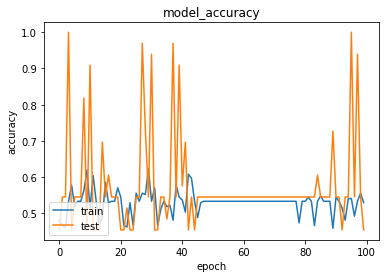

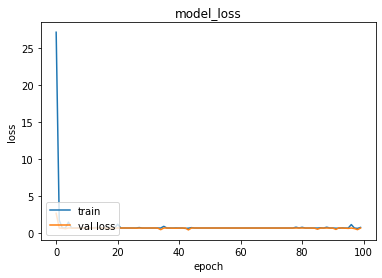

0.5298507213592529


In [67]:
'''
The accuracy and the losses at each iteration/epoch is evaluated in the graph below
matplotlib is used for plotting.
 
'''
def plot_metrics(model):
  plt.plot(model.history['accuracy'])
  plt.plot(model.history['val_accuracy'])
  plt.title('model_accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train','test'],loc='lower left')
  plt.show()

  plt.plot(model.history['loss'])
  plt.plot(model.history['val_loss'])
  plt.title('model_loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train','val loss'],loc='lower left')
  plt.show()


plot_metrics(trained_model)
print(trained_model.history['accuracy'][-1])

#**Testing for Cancer vs Normal**

In [68]:
def check_for_cancer(model,image_path):
  img = image.load_img(image_path, target_size=(227, 227)) # loading the image in 300x300 diemensions(227x227x3 for AlexNet)
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)#expanding along one axis 
  model = keras.models.load_model(model)
  result_vector = model.predict(img).round(3) #the array is passed to the model for prediction
  if result_vector[0] == 0:
      return "Cancer cell"
  else:
      return "Normal cell"
 
#print(check_for_cancer('/content/drive/MyDrive/Binary Classifier Models /Binary Classifier Model 0/Binary_Classifier_Model.h5','/content/drive/MyDrive/Architecture Datasets/Testing/Blasts/Im001_1.jpg'))
#print(check_for_cancer('/content/drive/MyDrive/Binary Classifier Models /Binary Classifier Model 0/Binary_Classifier_Model.h5','/content/drive/MyDrive/Architecture Datasets/Validation/Normal/Im034_0.jpg'))
# print(check_for_cancer('/content/drive/MyDrive/Binary Classifier Models /Binary Classifier Model 0/Binary_Classifier_Model.h5','/content/drive/MyDrive/Architecture Datasets/Testing/Blasts/Im001_1.tif'))
print(check_for_cancer('/content/drive/MyDrive/Binary Classifier Models /AlexNet Based Model/AlexNet_Classifier_Model.h5','/content/drive/MyDrive/Architecture Datasets/Testing/Normal/Im066_0.jpg'))

Normal cell
